# Station Clustering for Bike Demand Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from math import radians, cos, sin, asin, sqrt

In [ ]:
df_merged = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_merged.csv', low_memory=False)

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013116 entries, 0 to 1013115
Data columns (total 31 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             1013116 non-null  object 
 1   rideable_type       1013116 non-null  object 
 2   started_at          1013116 non-null  object 
 3   ended_at            1013116 non-null  object 
 4   start_station_name  1013116 non-null  object 
 5   start_station_id    1013116 non-null  object 
 6   end_station_name    1013116 non-null  object 
 7   end_station_id      1013116 non-null  object 
 8   start_lat           1013116 non-null  float64
 9   start_lng           1013116 non-null  float64
 10  end_lat             1013116 non-null  float64
 11  end_lng             1013116 non-null  float64
 12  member_casual       1013116 non-null  object 
 13  start_borough       1013116 non-null  object 
 14  end_borough         1013116 non-null  object 
 15  trip_duration  

In [ ]:
# Get stations from both start and end locations
start_stations = df_merged[['start_station_id', 'start_station_name', 'start_lat', 'start_lng', 'start_borough']].drop_duplicates()
start_stations.columns = ['station_id', 'station_name', 'lat', 'lng', 'borough']

end_stations = df_merged[['end_station_id', 'end_station_name', 'end_lat', 'end_lng', 'end_borough']].drop_duplicates()
end_stations.columns = ['station_id', 'station_name', 'lat', 'lng', 'borough']

# Combine and drop duplicates
all_stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset='station_id')

# Create station locations dataframe
station_locations = all_stations.groupby('station_id').agg({
    'lat': 'first',
    'lng': 'first',
    'station_name': 'first',
    'borough': 'first'
})

In [ ]:
print(f"Total stations: {len(station_locations)}")
station_locations.head()

Total stations: 1437


,lat,lng,station_name,borough
station_id,,,,
190 Morgan,40.711072,-73.932096,190 Morgan,Brooklyn
2733.03,40.633385,-74.016562,67 St & Erik Pl,Brooklyn
2782.02,40.635679,-74.020005,5 Ave & 67 St,Brooklyn
2821.06,40.635928,-74.013256,62 St & 7 Ave,Brooklyn
2832.03,40.637033,-74.022141,4 Ave & Shore Road Dr,Brooklyn


In [ ]:
df_merged['hour'] = pd.to_datetime(df_merged['started_at']).dt.hour
df_merged['day_of_week'] = pd.to_datetime(df_merged['started_at']).dt.dayofweek

def categorize_time(hour):
    if 7 <= hour <= 10:
        return 'morning_rush'
    elif 17 <= hour <= 20:
        return 'evening_rush'
    else:
        return 'other'

df_merged['time_period'] = df_merged['hour'].apply(categorize_time)
df_merged['time_period'].value_counts()

,count
time_period,
evening_rush,530331
morning_rush,482785


In [ ]:
demand_by_time = df_merged.groupby(['start_station_id', 'time_period']).size().unstack(fill_value=0)
demand_by_time.columns = [f'demand_{col}' for col in demand_by_time.columns]

supply_by_time = df_merged.groupby(['end_station_id', 'time_period']).size().unstack(fill_value=0)
supply_by_time.columns = [f'supply_{col}' for col in supply_by_time.columns]

print(f"Stations with demand data: {len(demand_by_time)}")
print(f"Stations with supply data: {len(supply_by_time)}")

Stations with demand data: 1427
Stations with supply data: 1420


In [ ]:
station_features = station_locations.join([demand_by_time, supply_by_time], how='outer').fillna(0)

# Rename to more clear columns
station_features['morning_leaving'] = station_features['demand_morning_rush']
station_features['morning_arriving'] = station_features['supply_morning_rush']
station_features['evening_leaving'] = station_features['demand_evening_rush']
station_features['evening_arriving'] = station_features['supply_evening_rush']

station_features['total_activity'] = (
    station_features['morning_leaving'] + station_features['morning_arriving'] +
    station_features['evening_leaving'] + station_features['evening_arriving']
)

station_features = station_features[['lat', 'lng', 'station_name', 'borough',
                                      'morning_leaving', 'morning_arriving',
                                      'evening_leaving', 'evening_arriving',
                                      'total_activity']]
station_features = station_features.reset_index().rename(columns={'index': 'station_id'})

print(f"Dataset shape: {station_features.shape}")
print(f"\nBorough distribution:")
print(station_features['borough'].value_counts())


Dataset shape: (1437, 10)

Borough distribution:
borough
Brooklyn     724
Manhattan    713
Name: count, dtype: int64


### Haversine Distance Matrix

In [ ]:
def haversine_distance(lat1, lng1, lat2, lng2):
    # Calculate great circle distance in km between two points
    lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    dlat = lat2 - lat1
    dlng = lng2 - lng1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    c = 2 * asin(sqrt(a))
    return c * 6371

n_stations = len(station_features)
coords = station_features[['lat', 'lng']].values
haversine_matrix = np.zeros((n_stations, n_stations))

for i in range(n_stations):
    for j in range(i+1, n_stations):
        dist = haversine_distance(coords[i,0], coords[i,1], coords[j,0], coords[j,1])
        haversine_matrix[i,j] = dist
        haversine_matrix[j,i] = dist

print(f"Distance matrix: {haversine_matrix.shape}")
print(f"Max distance: {haversine_matrix.max():.2f} km")
print(f"Mean distance: {haversine_matrix[haversine_matrix > 0].mean():.2f} km")

Distance matrix: (1437, 1437)
Max distance: 28.51 km
Mean distance: 7.93 km


### Explore Distance Thresholds

In [ ]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]
results = []

for threshold in thresholds:
    clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=threshold,
        metric='precomputed',
        linkage='average'
    )
    labels = clustering.fit_predict(haversine_matrix)
    n_clusters = len(np.unique(labels))
    avg_size = n_stations / n_clusters
    results.append({'threshold': threshold, 'n_clusters': n_clusters, 'avg_size': avg_size})
    print(f"{threshold:.1f} km → {n_clusters} clusters (avg {avg_size:.1f} stations/cluster)")

0.2 km → 1054 clusters (avg 1.4 stations/cluster)
0.3 km → 644 clusters (avg 2.2 stations/cluster)
0.4 km → 426 clusters (avg 3.4 stations/cluster)
0.5 km → 297 clusters (avg 4.8 stations/cluster)
0.6 km → 209 clusters (avg 6.9 stations/cluster)
0.8 km → 126 clusters (avg 11.4 stations/cluster)
1.0 km → 82 clusters (avg 17.5 stations/cluster)


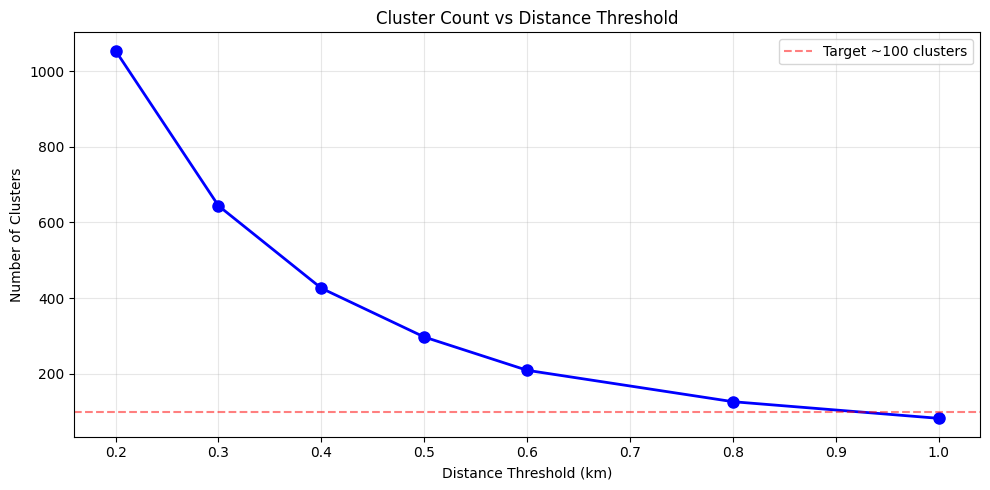

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([r['threshold'] for r in results], [r['n_clusters'] for r in results], 'bo-', linewidth=2, markersize=8)
ax.axhline(y=100, color='r', linestyle='--', alpha=0.5, label='Target ~100 clusters')
ax.set_xlabel('Distance Threshold (km)')
ax.set_ylabel('Number of Clusters')
ax.set_title('Cluster Count vs Distance Threshold')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

### Stage 1: Borough-Constrained Geographic Clustering

In [ ]:
Distance_threshold_km = 0.9

station_features['geo_cluster'] = -1
current_cluster_id = 0

for borough in station_features['borough'].unique():
    borough_mask = station_features['borough'] == borough
    borough_indices = station_features[borough_mask].index.tolist()
    n_borough_stations = len(borough_indices)

    if n_borough_stations == 0:
        continue

    if n_borough_stations == 1:
        station_features.loc[borough_indices, 'geo_cluster'] = current_cluster_id
        print(f"{borough}: 1 station → 1 cluster")
        current_cluster_id += 1
        continue

    borough_matrix = haversine_matrix[np.ix_(borough_indices, borough_indices)]

    borough_clustering = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=Distance_threshold_km,
        metric='precomputed',
        linkage='average'
    )
    borough_labels = borough_clustering.fit_predict(borough_matrix)

    station_features.loc[borough_indices, 'geo_cluster'] = borough_labels + current_cluster_id

    n_borough_clusters = len(np.unique(borough_labels))
    print(f"{borough}: {n_borough_stations} stations → {n_borough_clusters} clusters")
    current_cluster_id += n_borough_clusters

n_geo_clusters = station_features['geo_cluster'].nunique()
print(f"\nStage 1 Complete: {n_geo_clusters} geographic clusters")
print(f"Threshold: {Distance_threshold_km} km")

Brooklyn: 724 stations → 53 clusters
Manhattan: 713 stations → 48 clusters

Stage 1 Complete: 101 geographic clusters
Threshold: 0.9 km


### Stage 2: Demand Sub-Clustering

In [ ]:
Demand_k = 2
demand_features = ['morning_leaving', 'morning_arriving', 'evening_leaving', 'evening_arriving']

demand_scaler = StandardScaler()
demand_scaled = demand_scaler.fit_transform(station_features[demand_features])

station_features['demand_subcluster'] = -1
skipped_clusters = 0

for geo_id in range(n_geo_clusters):
    mask = station_features['geo_cluster'] == geo_id
    n_stations_in_geo = mask.sum()

    if n_stations_in_geo < Demand_k:
        station_features.loc[mask, 'demand_subcluster'] = 0
        skipped_clusters += 1
    else:
        X_demand = demand_scaled[mask.values]
        kmeans = KMeans(n_clusters=Demand_k, random_state=42, n_init=10)
        subclusters = kmeans.fit_predict(X_demand)
        station_features.loc[mask, 'demand_subcluster'] = subclusters

station_features['cluster'] = (
    station_features['geo_cluster'] * Demand_k +
    station_features['demand_subcluster']
).astype(int)

n_final_clusters = station_features['cluster'].nunique()
print(f"Skipped {skipped_clusters} geo clusters with < {Demand_k} stations")
print(f"Geographic clusters: {n_geo_clusters}")
print(f"Final clusters: {n_final_clusters}")
print(f"Avg stations per cluster: {len(station_features) / n_final_clusters:.1f}")

Skipped 3 geo clusters with < 2 stations
Geographic clusters: 101
Final clusters: 199
Avg stations per cluster: 7.2


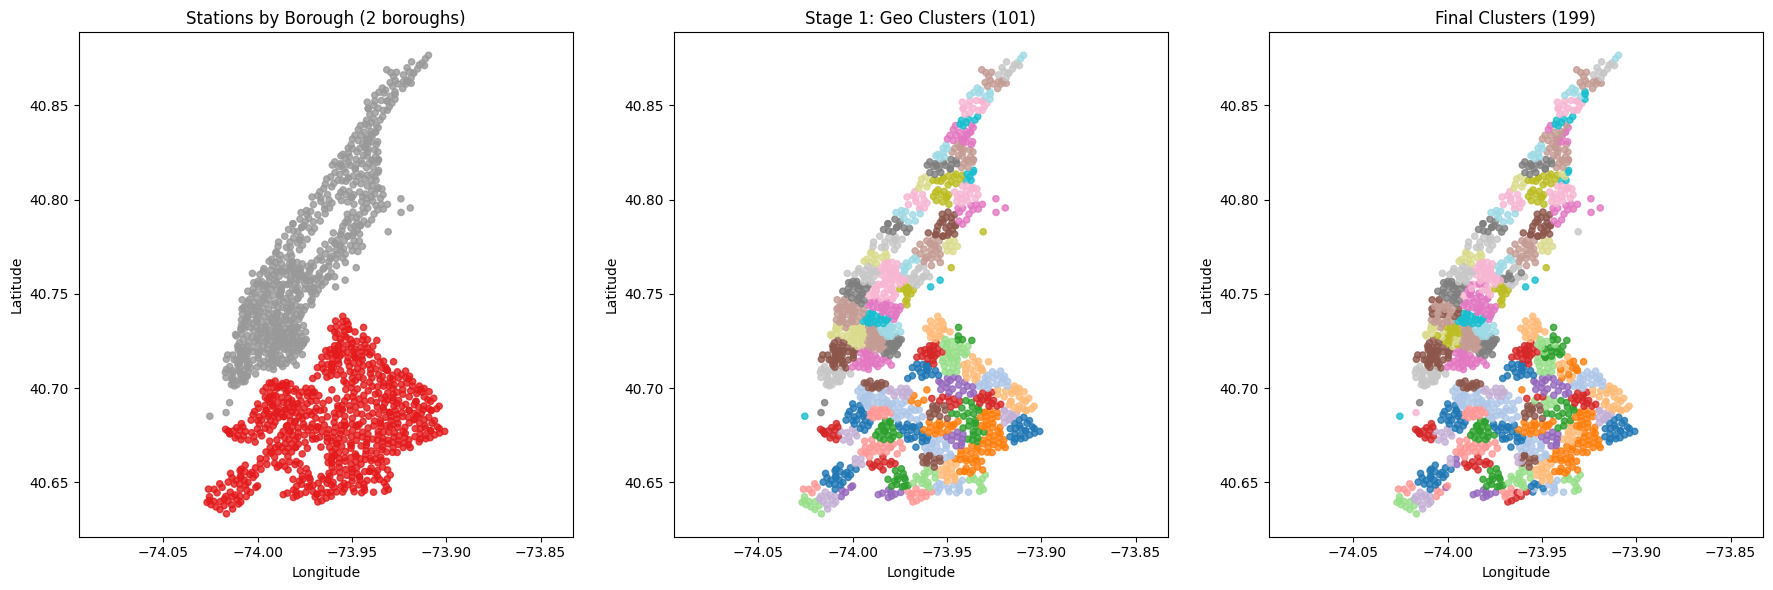

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Stations by Borough
borough_codes = station_features['borough'].astype('category').cat.codes
axes[0].scatter(station_features['lng'], station_features['lat'], c=borough_codes, cmap='Set1', s=20, alpha=0.8)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title(f'Stations by Borough ({station_features["borough"].nunique()} boroughs)')
axes[0].axis('equal')

# Geographic Clusters (Stage 1)
axes[1].scatter(station_features['lng'], station_features['lat'], c=station_features['geo_cluster'], cmap='tab20', s=20, alpha=0.8)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title(f'Stage 1: Geo Clusters ({n_geo_clusters})')
axes[1].axis('equal')

# Final Clusters (Stage 1 + 2)
axes[2].scatter(station_features['lng'], station_features['lat'], c=station_features['cluster'], cmap='tab20', s=20, alpha=0.8)
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
axes[2].set_title(f'Final Clusters ({n_final_clusters})')
axes[2].axis('equal')

plt.tight_layout()
plt.show()

### Create Cluster Assignments

In [ ]:
# Create station clusters dataframe (kept in memory for merging)
station_clusters = station_features[['station_id', 'cluster', 'geo_cluster', 'borough', 'station_name', 'lat', 'lng']].copy()

print(f"Station clusters created (in memory)")
print(f"Stations: {len(station_clusters)}")
print(f"Geographic clusters: {station_clusters['geo_cluster'].nunique()}")
print(f"Final clusters: {station_clusters['cluster'].nunique()}")
station_clusters.head()

Station clusters created (in memory)
Stations: 1437
Geographic clusters: 101
Final clusters: 199


,station_id,cluster,geo_cluster,borough,station_name,lat,lng
0,190 Morgan,30,15,Brooklyn,190 Morgan,40.711072,-73.932096
1,2733.03,53,26,Brooklyn,67 St & Erik Pl,40.633385,-74.016562
2,2782.02,53,26,Brooklyn,5 Ave & 67 St,40.635679,-74.020005
3,2821.06,98,49,Brooklyn,62 St & 7 Ave,40.635928,-74.013256
4,2832.03,53,26,Brooklyn,4 Ave & Shore Road Dr,40.637033,-74.022141


### Merge with Bike Changes Data

In [ ]:
bike_changes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bike_changes_model.csv')

bike_changes['station_id'] = bike_changes['station_id'].astype(str).str.strip()
station_clusters['station_id'] = station_clusters['station_id'].astype(str).str.strip()

bike_ids = set(bike_changes['station_id'].unique())
cluster_ids = set(station_clusters['station_id'].unique())
overlap = bike_ids.intersection(cluster_ids)

print(f"Station ID matching:")
print(f"  In bike_changes: {len(bike_ids)}")
print(f"  In station_clusters: {len(cluster_ids)}")
print(f"  Matching: {len(overlap)}")

bike_changes_with_clusters = bike_changes.merge(
    station_clusters[['station_id', 'cluster', 'geo_cluster']],
    on='station_id',
    how='left'
)

missing = bike_changes_with_clusters['cluster'].isna().sum()
total = len(bike_changes_with_clusters)
print(f"\nMerge results: {total - missing:,} with clusters ({(total - missing)/total*100:.1f}%)")

if 0 < missing < total:
    bike_changes_with_clusters = bike_changes_with_clusters.dropna(subset=['cluster'])
    bike_changes_with_clusters['cluster'] = bike_changes_with_clusters['cluster'].astype(int)
    bike_changes_with_clusters['geo_cluster'] = bike_changes_with_clusters['geo_cluster'].astype(int)

/tmp/ipython-input-3399217993.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  bike_changes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bike_changes_model.csv')


Station ID matching:
  In bike_changes: 1329
  In station_clusters: 1437
  Matching: 1327

Merge results: 224,556 with clusters (99.9%)


In [ ]:
# Data with clusters ready (kept in memory for aggregation)
print(f"Merged data shape: {bike_changes_with_clusters.shape}")
print(f"\nCluster features for modeling:")
print(f"  'cluster': {bike_changes_with_clusters['cluster'].nunique()} final clusters")
print(f"  'geo_cluster': {bike_changes_with_clusters['geo_cluster'].nunique()} geographic clusters")

Merged data shape: (224556, 39)

Cluster features for modeling:
  'cluster': 197 final clusters
  'geo_cluster': 100 geographic clusters


In [ ]:
bike_changes_with_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224556 entries, 0 to 224679
Data columns (total 39 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   station_id              224556 non-null  object 
 1   date                    224556 non-null  object 
 2   time_interval           224556 non-null  object 
 3   cumulative_bikes        224556 non-null  int64  
 4   hour                    224556 non-null  int64  
 5   day_of_week             224556 non-null  int64  
 6   is_morning_rush         224556 non-null  int64  
 7   is_evening_rush         224556 non-null  int64  
 8   cumulative_bikes_lag1   224556 non-null  float64
 9   cumulative_bikes_lag2   224556 non-null  float64
 10  cumulative_bikes_lag4   224556 non-null  float64
 11  rate_of_change          224556 non-null  float64
 12  rate_of_change_lag1     224556 non-null  float64
 13  rolling_mean_4          224556 non-null  float64
 14  rolling_std_4           2

In [ ]:
bike_changes_with_clusters.head(25)

,station_id,date,time_interval,cumulative_bikes,hour,day_of_week,is_morning_rush,is_evening_rush,cumulative_bikes_lag1,cumulative_bikes_lag2,...,windspeed,is_raining,classic_bike_count,casual_count,avg_trip_duration.1,median_trip_duration.1,electric_bike_count.1,member_count.1,cluster,geo_cluster
0,2733.03,2024-08-02,2024-08-02 18:15:00,-7,18,4,0,1,-6.0,-3.0,...,0.0,0,1.0,1.0,13.0,13.0,0.0,0.0,53,26
1,2733.03,2024-08-13,2024-08-13 18:45:00,0,18,1,0,1,1.0,0.0,...,8.2,0,1.0,0.0,14.5,14.5,0.0,1.0,53,26
2,2733.03,2024-08-14,2024-08-14 18:30:00,2,18,2,0,1,3.0,2.0,...,8.6,0,1.0,0.0,4.5,4.5,0.0,1.0,53,26
3,2733.03,2024-08-14,2024-08-14 18:45:00,1,18,2,0,1,2.0,3.0,...,8.6,0,2.0,0.0,9.5,9.5,0.0,2.0,53,26
4,2733.03,2024-08-16,2024-08-16 18:30:00,1,18,4,0,1,1.0,0.0,...,3.9,0,0.0,0.0,19.0,19.0,1.0,1.0,53,26
5,2733.03,2024-08-19,2024-08-19 18:30:00,-1,18,0,0,1,0.0,-1.0,...,3.9,0,1.0,0.0,7.0,7.0,0.0,1.0,53,26
6,2733.03,2024-08-22,2024-08-22 18:15:00,-3,18,3,0,1,-2.0,-1.0,...,3.8,0,0.0,0.0,19.5,19.5,1.0,1.0,53,26
7,2733.03,2024-08-26,2024-08-26 18:30:00,-2,18,0,0,1,-2.0,-3.0,...,11.5,0,1.0,0.0,7.0,7.0,0.0,1.0,53,26
8,2733.03,2024-08-27,2024-08-27 17:15:00,-1,17,1,0,1,-2.0,-1.0,...,3.5,0,0.0,1.0,10.5,10.5,1.0,0.0,53,26
9,2733.03,2024-08-29,2024-08-29 18:00:00,-3,18,3,0,1,-2.0,-1.0,...,7.3,0,0.0,1.0,4.0,4.0,1.0,0.0,53,26


### Aggregate Data by Cluster for Modeling

This step aggregates all station-level data to **cluster-level data**, where each row represents one cluster at one time interval. This follows the approach from the paper where predictions are made for entire clusters rather than individual stations.

In [ ]:
# ============================================================
# AGGREGATE STATION DATA TO CLUSTER LEVEL
# ============================================================

# Ensure time_interval is datetime
bike_changes_with_clusters['time_interval'] = pd.to_datetime(bike_changes_with_clusters['time_interval'])

print(f"Original data shape: {bike_changes_with_clusters.shape}")
print(f"Number of unique clusters: {bike_changes_with_clusters['cluster'].nunique()}")
print(f"Number of unique time intervals: {bike_changes_with_clusters['time_interval'].nunique()}")

# Define aggregation rules for each column type
agg_dict = {
    # Target: Sum cumulative_bikes across stations in each cluster
    'cumulative_bikes': 'sum',
    'net_change': 'sum',

    # Temporal features: Take first (same for all stations at same time)
    'hour': 'first',
    'day_of_week': 'first',
    'is_morning_rush': 'first',
    'is_evening_rush': 'first',

    # Trip features: Mean across cluster
    'avg_trip_duration': 'mean',
    'median_trip_duration': 'mean',

    # Count features: Sum across cluster
    'electric_bike_count': 'sum',
    'classic_bike_count': 'sum',
    'member_count': 'sum',
    'casual_count': 'sum',

    # Location features: Mean (cluster centroid)
    'lat': 'mean',
    'lng': 'mean',
    'distance_from_center': 'mean',

    # Historical features: Mean/Sum
    'total_historical_rides': 'sum',
    'avg_trip_duration_hist': 'mean',
    'std_trip_duration': 'mean',
    'member_proportion_hist': 'mean',

    # Weather: First (same for all stations)
    'temp': 'first',
    'windspeed': 'first',
    'is_raining': 'first',

    # Station count per cluster
    'station_id': 'count'
}

# Only aggregate columns that exist in data
existing_cols = {col: func for col, func in agg_dict.items() if col in bike_changes_with_clusters.columns}
print(f"\nAggregating {len(existing_cols)} columns...")

# Aggregate by cluster and time_interval
cluster_aggregated = bike_changes_with_clusters.groupby(['geo_cluster', 'time_interval']).agg(existing_cols).reset_index()


# Rename station_id count to station_count
if 'station_id' in cluster_aggregated.columns:
    cluster_aggregated = cluster_aggregated.rename(columns={'station_id': 'station_count'})

print(f"\n✅ Aggregated data shape: {cluster_aggregated.shape}")
print(f"Rows reduced from {len(bike_changes_with_clusters):,} to {len(cluster_aggregated):,}")
print(f"Data reduction: {100*(1-len(cluster_aggregated)/len(bike_changes_with_clusters)):.1f}%")

Original data shape: (224556, 39)
Number of unique clusters: 197
Number of unique time intervals: 308

Aggregating 22 columns...

✅ Aggregated data shape: (25329, 24)
Rows reduced from 224,556 to 25,329
Data reduction: 88.7%


In [ ]:
# RECALCULATE LAG FEATURES AND RATES OF CHANGE BASED ON AGGREGATED CLUSTER DATA

# Step 2: RECALCULATE lag and derived features on aggregated data
cluster_aggregated = cluster_aggregated.sort_values(['geo_cluster', 'time_interval'])

# Lag features (per cluster)
cluster_aggregated['cumulative_bikes_lag1'] = cluster_aggregated.groupby('geo_cluster')['cumulative_bikes'].shift(1)
cluster_aggregated['cumulative_bikes_lag2'] = cluster_aggregated.groupby('geo_cluster')['cumulative_bikes'].shift(2)
cluster_aggregated['cumulative_bikes_lag4'] = cluster_aggregated.groupby('geo_cluster')['cumulative_bikes'].shift(4)

# Rate of change
cluster_aggregated['rate_of_change'] = cluster_aggregated.groupby('geo_cluster')['cumulative_bikes'].pct_change()
cluster_aggregated['rate_of_change_lag1'] = cluster_aggregated.groupby('geo_cluster')['rate_of_change'].shift(1)

# Rolling features
cluster_aggregated['rolling_mean_4'] = cluster_aggregated.groupby('geo_cluster')['cumulative_bikes'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)
cluster_aggregated['rolling_std_4'] = cluster_aggregated.groupby('geo_cluster')['cumulative_bikes'].transform(
    lambda x: x.rolling(window=4, min_periods=1).std()
)

In [ ]:
cluster_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25329 entries, 0 to 25328
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   geo_cluster             25329 non-null  int64         
 1   time_interval           25329 non-null  datetime64[ns]
 2   cumulative_bikes        25329 non-null  int64         
 3   hour                    25329 non-null  int64         
 4   day_of_week             25329 non-null  int64         
 5   is_morning_rush         25329 non-null  int64         
 6   is_evening_rush         25329 non-null  int64         
 7   avg_trip_duration       25329 non-null  float64       
 8   median_trip_duration    25329 non-null  float64       
 9   electric_bike_count     25329 non-null  float64       
 10  classic_bike_count      25329 non-null  float64       
 11  member_count            25329 non-null  float64       
 12  casual_count            25329 non-null  float6

In [ ]:
# ============================================================
# VERIFY AGGREGATION AND SAVE
# ============================================================

print("Columns in aggregated cluster data:")
for i, col in enumerate(cluster_aggregated.columns, 1):
    print(f"  {i:2}. {col}")

print(f"\n📊 Summary Statistics for Target (cumulative_bikes):")
print(f"   Min: {cluster_aggregated['cumulative_bikes'].min():.0f}")
print(f"   Max: {cluster_aggregated['cumulative_bikes'].max():.0f}")
print(f"   Mean: {cluster_aggregated['cumulative_bikes'].mean():.1f}")
print(f"   Std: {cluster_aggregated['cumulative_bikes'].std():.1f}")

# Show sample of aggregated data
print(f"\nSample of aggregated cluster data:")
cluster_aggregated.head()

Columns in aggregated cluster data:
   1. geo_cluster
   2. time_interval
   3. cumulative_bikes
   4. hour
   5. day_of_week
   6. is_morning_rush
   7. is_evening_rush
   8. avg_trip_duration
   9. median_trip_duration
  10. electric_bike_count
  11. classic_bike_count
  12. member_count
  13. casual_count
  14. lat
  15. lng
  16. distance_from_center
  17. total_historical_rides
  18. avg_trip_duration_hist
  19. std_trip_duration
  20. member_proportion_hist
  21. temp
  22. windspeed
  23. is_raining
  24. station_count
  25. cumulative_bikes_lag1
  26. cumulative_bikes_lag2
  27. cumulative_bikes_lag4
  28. rate_of_change
  29. rate_of_change_lag1
  30. rolling_mean_4
  31. rolling_std_4

📊 Summary Statistics for Target (cumulative_bikes):
   Min: -437
   Max: 915
   Mean: -21.9
   Std: 90.9

Sample of aggregated cluster data:


,geo_cluster,time_interval,cumulative_bikes,hour,day_of_week,is_morning_rush,is_evening_rush,avg_trip_duration,median_trip_duration,electric_bike_count,...,windspeed,is_raining,station_count,cumulative_bikes_lag1,cumulative_bikes_lag2,cumulative_bikes_lag4,rate_of_change,rate_of_change_lag1,rolling_mean_4,rolling_std_4
0,0,2024-08-01 08:00:00,9,8,3,1,0,10.706667,8.900000,13.0,...,4.6,0,5,NaN,NaN,NaN,NaN,NaN,9.000000,NaN
1,0,2024-08-01 08:15:00,18,8,3,1,0,10.300000,10.300000,9.0,...,4.6,0,10,9.0,NaN,NaN,1.000000,NaN,13.500000,6.363961
2,0,2024-08-01 08:30:00,16,8,3,1,0,11.118056,10.270833,28.0,...,4.6,0,12,18.0,9.0,NaN,-0.111111,1.000000,14.333333,4.725816
3,0,2024-08-01 08:45:00,18,8,3,1,0,9.452778,9.437500,26.0,...,4.6,0,12,16.0,18.0,NaN,0.125000,-0.111111,15.250000,4.272002
4,0,2024-08-01 09:00:00,33,9,3,1,0,11.778125,12.046875,24.0,...,0.5,0,16,18.0,16.0,9.0,0.833333,0.125000,21.250000,7.889867


In [ ]:
# ============================================================
# SAVE AGGREGATED CLUSTER DATA
# ============================================================

# Save to CSV
cluster_aggregated.to_csv('/content/drive/MyDrive/Colab Notebooks/bike_changes_cluster_aggregated.csv', index=False)

print("✅ Saved aggregated cluster data to 'data/bike_changes_cluster_aggregated.csv'")
print(f"\nFinal dataset summary:")
print(f"  Shape: {cluster_aggregated.shape}")
print(f"  Clusters: {cluster_aggregated['geo_cluster'].nunique()}")
print(f"  Time intervals: {cluster_aggregated['time_interval'].nunique()}")
print(f"  Date range: {cluster_aggregated['time_interval'].min()} to {cluster_aggregated['time_interval'].max()}")

✅ Saved aggregated cluster data to 'data/bike_changes_cluster_aggregated.csv'

Final dataset summary:
  Shape: (25329, 31)
  Clusters: 100
  Time intervals: 308
  Date range: 2024-08-01 08:00:00 to 2024-08-30 18:45:00
